# Colab 한글 설치

- 한글 설치하는 코드입니다.

In [1]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'sudo apt autoremove' to remove it.
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 19 not upgraded.
Need to get 9,604 kB of archives.
After this operation, 29.5 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 fonts-nanum all 20170925-1 [9,604 kB]
Fetched 9,604 kB in 0s (45.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype

- 런타임 다시 시작한 뒤, 다음 코드를 실행시킵니다.

In [1]:
import matplotlib.font_manager as fm
fm._rebuild()

# 1. 개발 환경 소개

- Google Colab CPU 환경에서 진행했습니다.
- 개발 환경은 다음과 같습니다.

In [ ]:
import platform
print('- os:',platform.platform())
print('- 운영체제:', end="")
!cat /etc/issue.net
print('- Process information:', platform.processor())
print('- Process Architecture:', platform.machine())
print("- RAM: 12.68GB")

- os: Linux-5.4.188+-x86_64-with-Ubuntu-18.04-bionic
- 운영체제:Ubuntu 18.04.6 LTS
- Process information: x86_64
- Process Architecture: x86_64
- RAM: 12.68GB


# 2. 라이브러리 불러오기 및 경로 저장

### 라이브러리 불러오기

In [2]:
# 전처리 라이브러리
import pandas as pd
import numpy as np
import os
from sklearn.cluster import KMeans

# 시각화 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 폰트 설정
plt.rc('font', family='NanumBarunGothic') 

# 마이너스 기호 출력
plt.rc('axes', unicode_minus=False)

# 분석에 문제가 없는 경고 메시지 숨김
import warnings
warnings.filterwarnings('ignore')

### 라이브러리버전

In [ ]:
print('- ', end="")
!python --version
print('- pandas:', pd.__version__)
print('- numpy:', np.__version__)

- Python 3.7.13
- pandas: 1.3.5
- numpy: 1.21.6


### 경로 설정 및 데이터 불러오기

In [3]:
# 구글 드라이브 연결
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


코드 실행을 위해 경로를 설정합니다.

In [4]:
data_dir = '/content/drive/MyDrive/롯데멤버스_경진대회/3. 안다비젼_ 데이터 및 모델 세이브 파일/'

In [5]:
# 데이터 불러오기
demo = pd.read_csv(data_dir+'data/LPOINT_BIG_COMP_01_DEMO.csv')
pdde = pd.read_csv(data_dir+'data/LPOINT_BIG_COMP_02_PDDE.csv', parse_dates=[['de_dt', 'de_hr']])
pd_clac = pd.read_csv(data_dir+'data/LPOINT_BIG_COMP_04_PD_CLAC.csv')

# 3. RFM 분석

- K-means를 통해 RFM을 분석합니다.

In [6]:
# 군집 정렬 함수
def order_cluster(cluster_name, target_name, df, ascending):
    new = df.groupby(cluster_name)[target_name].mean().reset_index()
    new = new.sort_values(by=target_name, ascending=ascending).reset_index(drop=True)
    new['index'] = new.index
    final = pd.merge(df, new[[cluster_name, 'index']], on=cluster_name)
    final = final.drop([cluster_name], axis=1)
    final = final.rename(columns={'index':cluster_name})
    return final

# 온라인 구매 데이터 사용
pdde2 = pd.merge(pdde, pd_clac, on='pd_c')
pdde_on = pdde2[pdde2['chnl_dv']==2]

# Recency 도출을 위한 데이터 추출
pdde_on['de_dt_de_hr'] = pdde_on['de_dt_de_hr'].str.replace('\s(\d)$', ' 0\\1')
pdde_on['timestamp'] = pd.to_datetime(pdde_on['de_dt_de_hr'])
users = pd.DataFrame(pdde_on['cust'])
users.columns = ['cust']
recent = pdde_on.groupby('cust')['timestamp'].max().reset_index() # 최근 구매 날짜
recent.rename(columns = {'timestamp':'recent_buy'}, inplace=True)

# 가장 최근 날짜에서 고객번호별 최근 구매날짜 차이 구하기
recent['recency'] = (recent['recent_buy'].max() - recent['recent_buy']).dt.days
users = pd.merge(users, recent[['cust','recency']], on='cust')

# Recency cluster 기준 산정
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(users[['recency']])
users['recency_cluster'] = kmeans.predict(users[['recency']])
users = order_cluster('recency_cluster', 'recency', users, False)

# Frequency 도출을 위한 데이터 추출
frequency = pdde_on.groupby('cust')['timestamp'].count().reset_index()
frequency.rename(columns = {'timestamp':'frequency'}, inplace=True)
users = pd.merge(users, frequency, on='cust')

# Frequency cluster 기준 산정
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(users[['frequency']])
users['frequency_cluster'] = kmeans.predict(users[['frequency']])
users = order_cluster('frequency_cluster', 'frequency', users, True)

# Monetary 도출을 위한 데이터 추출
revenue = pdde_on.groupby('cust')['buy_am'].sum().reset_index()
users = pd.merge(users, revenue, on='cust')

# Monetary cluster 기준 산정
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(users[['buy_am']])
users['revenue_cluster'] = kmeans.predict(users[['buy_am']])
users = order_cluster('revenue_cluster', 'buy_am', users, True)

### Recency 기준 산정

- 각 군집의 min, max 값으로 Recency 기준을 산정합니다.

In [ ]:
users.groupby('recency_cluster')['recency'].describe()

,count,mean,std,min,25%,50%,75%,max
recency_cluster,,,,,,,,
0,14709.0,298.089469,27.893407,263.0,273.0,291.0,318.0,364.0
1,100035.0,227.849103,12.699205,188.0,222.0,225.0,234.0,262.0
2,52924.0,147.272523,23.225464,109.0,127.0,148.0,168.0,187.0
3,79278.0,69.534373,17.845901,41.0,55.0,69.0,84.0,108.0
4,181555.0,11.687814,10.535333,0.0,3.0,9.0,18.0,40.0


### Frequency 기준 산정

- 각 군집의 min, max 값으로 Frequency 기준을 산정합니다.

In [ ]:
users.groupby('frequency_cluster')['frequency'].describe()

,count,mean,std,min,25%,50%,75%,max
frequency_cluster,,,,,,,,
0,185201.0,78.991220,50.615071,1.0,33.0,76.0,122.0,171.0
1,138098.0,265.638213,58.360064,172.0,218.0,260.0,309.0,380.0
2,75070.0,495.810843,77.034842,384.0,428.0,484.0,557.0,652.0
3,26999.0,811.699359,127.848195,660.0,717.0,759.0,867.0,1108.0
4,3133.0,1587.529205,180.306404,1385.0,1385.0,1748.0,1748.0,1748.0


### Monetary 기준 산정

- 각 군집의 min, max 값으로 Monetary 기준을 산정합니다.

In [ ]:
users.groupby('revenue_cluster')['buy_am'].describe()

,count,mean,std,min,25%,50%,75%,max
revenue_cluster,,,,,,,,
0,272911.0,1.141707e+06,6.513954e+05,100.0,588430.0,1111640.0,1683630.0,2364930.0
1,128845.0,3.584730e+06,9.059400e+05,2369040.0,2815580.0,3435300.0,4144370.0,5994100.0
2,23097.0,8.480505e+06,2.474894e+06,6127738.0,6878150.0,7976000.0,8834480.0,18438560.0
3,2467.0,2.873522e+07,6.129186e+06,20833830.0,20833830.0,30021600.0,32813000.0,39984540.0
4,1181.0,5.573117e+07,4.531273e+06,49767200.0,49767200.0,59171000.0,59171000.0,59171000.0


# 4. 고객 세분화

- RFM 수치를 바탕으로 고객 세분화를 진행합니다.

In [7]:
# RFM 수치를 바탕으로 고객 스코어링 작업
users['overallscore'] = users['recency_cluster'] + users['frequency_cluster'] + users['revenue_cluster']

# 총 스코어링 점수
users.groupby('overallscore')['recency','frequency','buy_am'].mean()

# 점수가 1부터 시작하도록 함
users['recency_cluster']+=1
users['frequency_cluster']+=1
users['revenue_cluster']+=1

# 고객 세분화
segt_map = {
    r'[1-2][1-2]': '이탈한 고객',
    r'[1-2][3-4]': '이탈한 잠재 VIP',
    r'[1-2]5': '이탈한 VIP',
    r'3[1-2]': '이탈 우려',
    r'33': '신경써야 할 고객',
    r'[3-4][4-5]': '뜸한 VIP',
    r'41': '지금 잡아야 할 고객',
    r'51': '신규 고객',
    r'[4-5][2-3]': '잠재 VIP',
    r'5[4-5]': 'VIP'
}

users['Segment'] = users['recency_cluster'].map(str) + users['frequency_cluster'].map(str)
users['Segment'] = users['Segment'].replace(segt_map, regex=True)

### 고객 세분화 시각화

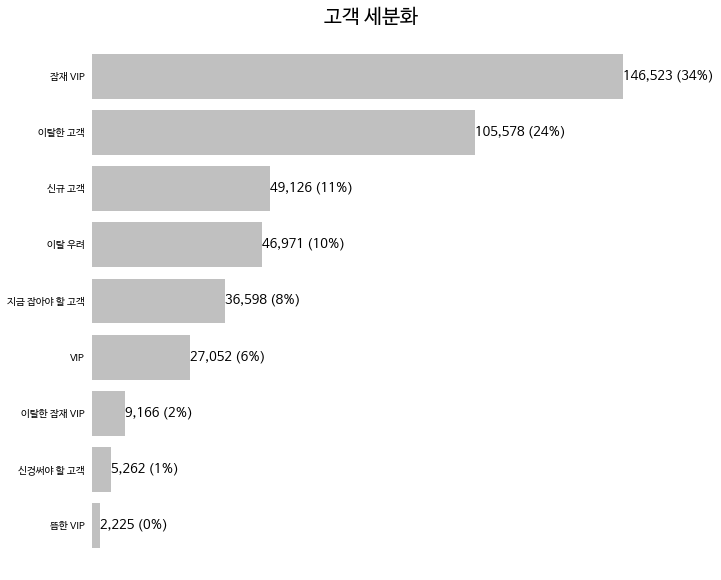

In [8]:
# 고객 세분화 시각화
segments_counts = users['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots(figsize=(10,10))

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='silver')
ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)
ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index)

for i, bar in enumerate(bars):
        value = bar.get_width()
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left',
                fontsize=13
               )
plt.title('고객 세분화', fontsize=20)
plt.show()

## 5. VIP 고객 분석

In [9]:
# 상품 카테고리 설정
cat_map = {
    '건해산물' : '식품',
    '과자' : '식품',
    '과일' : '식품',
    '냉동식품' : '식품',
    '냉장식품' : '식품',
    '대용식' : '식품',
    '병통조림' : '식품',
    '수산물' : '식품',
    '양곡' : '식품',
    '유제품' : '식품',
    '음료' : '식품',
    '조리식품' : '식품',
    '조미료' : '식품',
    '주류' : '식품',
    '채소' : '식품',
    '축산물' : '식품',
    '커피/차' : '식품',
    '건강식품' : '생활/건강',
    '건강용품' : '생활/건강',
    '공구/안전용품' : '생활/건강',
    '세제/위생' : '생활/건강',
    '식기/조리기구' : '생활/건강',
    '주방잡화' : '생활/건강',
    '청소/세탁/욕실용품' : '생활/건강',
    '유아동의류' : '출산유아동',
    '유아식품' : '출산유아동',
    '출산/육아용품' : '출산유아동',
    '남성의류' : '의류잡화',
    '속옷/양말/홈웨어' : '의류잡화',
    '스포츠패션' : '의류잡화',
    '여성의류' : '의류잡화',
    '패션잡화' : '의류잡화',
    '퍼스널케어' : '뷰티',
    '화장품/뷰티케어' : '뷰티',
    '구기/필드스포츠' : '스포츠/레저/자동차',
    '시즌스포츠' : '스포츠/레저/자동차',
    '아웃도어/레저' : '스포츠/레저/자동차',
    '자동차용품' : '스포츠/레저/자동차',
    '헬스/피트니스' : '스포츠/레저/자동차',
    '모바일' : '컴퓨터/게임/모바일',
    '컴퓨터' : '컴퓨터/게임/모바일',
    '계절가전' : '가전',
    '냉장/세탁가전' : '가전',
    '생활/주방가전' : '가전',
    '영상/음향가전' : '가전',
    '가구' : '가구/침구/인테리어',
    '인테리어/조명' : '가구/침구/인테리어',
    '침구/수예' : '가구/침구/인테리어',
    '문구/사무용품' : '반려/취미/문구/도서',
    '서적/음반/악기' : '반려/취미/문구/도서',
    '완구' : '반려/취미/문구/도서',
    '원예/애완' : '반려/취미/문구/도서',
    '상품권' : 'e쿠폰/여행/렌탈',
    '생활/렌탈서비스' : 'e쿠폰/여행/렌탈',
    '여행/레저서비스' : 'e쿠폰/여행/렌탈',
    '기타(비상품)' : '기타',
    '테넌트/음식점' : '기타'
    }

pdde_on['pd_category'] = pdde_on['clac_hlv_nm']
pdde_on['pd_category'] = pdde_on['clac_hlv_nm'].replace(cat_map)

# VIP 고객의 구매 비율
vip = users[(users['Segment']=='VIP')|(users['Segment']=='잠재 VIP')|(users['Segment']=='뜸한 VIP')]['cust'].tolist()
df_vip = pdde_on[pdde_on['cust'].isin(vip)]
vip_buy_rate = df_vip.groupby('pd_category')['buy_am'].sum()/pdde_on.groupby('pd_category')['buy_am'].sum()

### VIP 고객의 구매가 전체 매출 중 차지하는 비율

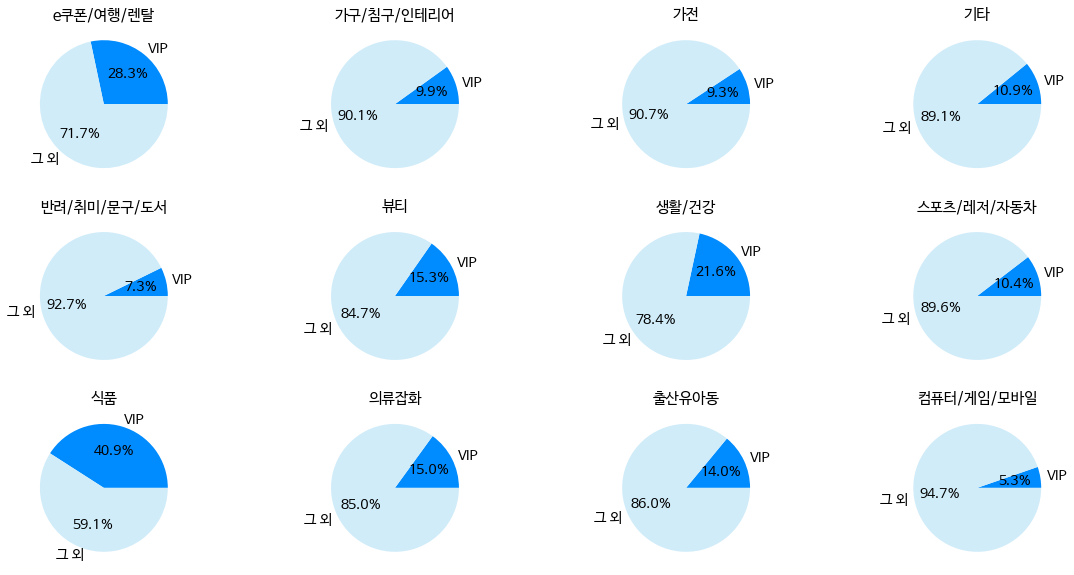

In [10]:
# VIP 고객의 구매가 전체 매출 중 차지하는 비율
colors = ['#008BFF', '#D0ECF9']
plt.figure(figsize=(20, 10), facecolor='white')
for i in range(len(vip_buy_rate)):
    plt.subplot(3, 4, i+1)
    plt.pie([vip_buy_rate[i], 1-vip_buy_rate[i]],
            labels = ['VIP', '그 외'], colors = colors, autopct='%.1f%%', textprops={'fontsize': 14})
    plt.title(vip_buy_rate.index[i], fontsize=15)
plt.show()

### VIP 고객 연령대 분포 시각화

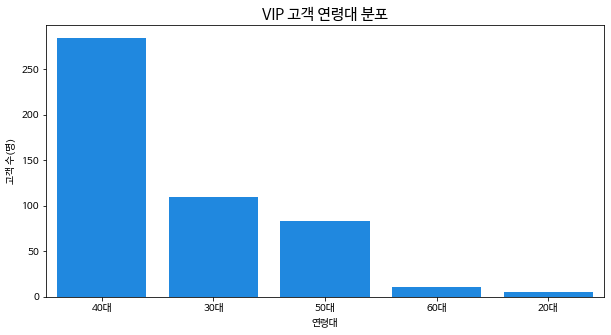

In [11]:
# VIP 고객 연령대 분석
demo_vip = demo[demo['cust'].isin(vip)]

plt.figure(figsize=(10, 5), facecolor="white")
sns.countplot(data=demo_vip, x='ages', order=demo_vip['ages'].value_counts().index, color = '#008BFF')
plt.ylabel('고객 수(명)')
plt.xlabel('연령대')
plt.title('VIP 고객 연령대 분포', fontsize=15)
plt.show()

### 전체 고객 연령대 분포 시각화

- vip 고객의 연령대 분포와 어떤 차이가 있는지 비교하기 위해 시각화합니다.

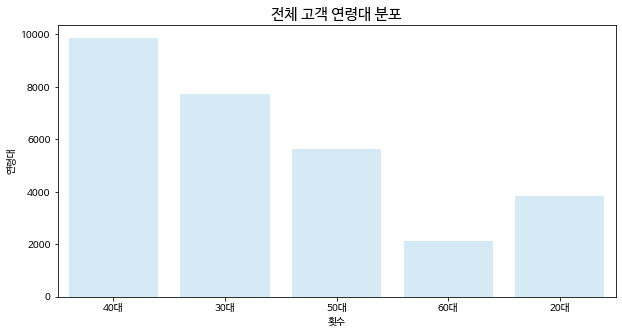

In [12]:
# 전체 고객 연령대 분포와 비교
plt.figure(figsize=(10, 5), facecolor="white")
sns.countplot(data=demo, x='ages', order=demo_vip['ages'].value_counts().index, color = '#D0ECF9')
plt.xlabel('횟수')
plt.ylabel('연령대')
plt.title('전체 고객 연령대 분포', fontsize=15)
plt.show()